In [3]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
from explainabilityModels import make_gradcam_heatmap as GradCam

In [4]:
N = 4000
size = 64
labels = np.random.randint(1, size = N)
imgs = np.zeros((size, size, N))




In [5]:
#fill array with corresponding images
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_blob_img(length=size, big = True, big_blob_size=8, big_blob_range=2)
    elif labels[i] == 1:
        x = generator.generate_blob_img(length=size, big = False)
    imgs[:,:,i] = x

In [6]:
#make gradcam heatmap for every image and normalise
heatmaps = np.zeros_like(imgs)
model = tf.keras.models.load_model("models/model20_BN/")

for img in range(N):
    heatmaps[:,:,img] = GradCam(imgs[:,:,img], model, -6, 0)
    heatmaps[:,:,img] /= heatmaps[:,:,img].sum()
    #heatmaps[:,:,img] = minmax_scale(heatmaps[:,:,img])



In [7]:
#get segmentation for every image
region_imgs = np.zeros_like(imgs, dtype=np.int64)

for img in range(N):
    region_imgs[:,:,img] = measure.label(imgs[:,:,img])

In [8]:
#find number of blobs in all images
num_blobs_array = []
for img in range(N):
    num_blobs_array.append(np.unique(region_imgs[:,:,img]).shape[0] - 1)

num_blobs = sum(num_blobs_array)
num_blobs

166823

In [41]:
num_blobs//imgs.shape[-1]

41

In [71]:
#generate interpretability scores for each blob; score is the sum of intensities of heatmap in the region
#plus get the highest score for every image
scores = np.zeros(num_blobs)
i = 0
highscores = []
for img in range(N):
    img_highscore = 0
    for region in np.unique(region_imgs[:,:,img]):   
        if region != 0:
            x = np.copy(region_imgs[:,:,img])
            x[x != region] = 0
            img_score = (heatmaps[:,:,img] * x).sum()
            scores[i] = img_score
            if img_score > img_highscore:
                img_highscore = img_score
            i += 1
    highscores.append(img_highscore)
        

In [76]:
highscores = np.asarray(highscores)
ind = np.where(np.in1d(scores, highscores))[0]
ind.shape

(4000,)

In [33]:
blob_areas = []
for img in range(N):
    areas = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['area'])).to_numpy().squeeze()
    blob_areas += areas.tolist()

blob_areas = np.asarray(blob_areas)
blob_areas.shape

(165891,)

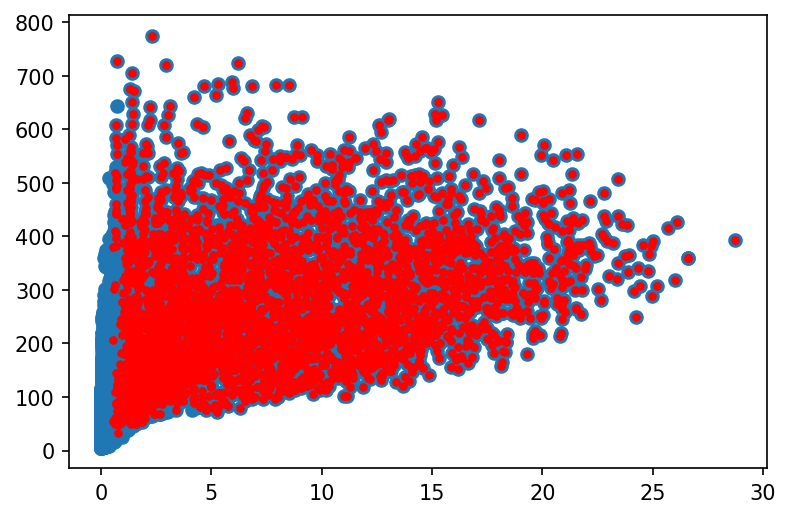

In [86]:
x = scores[ind]
y = blob_areas[ind]
fig= plt.figure()
fig.set_dpi(150)
plt.scatter(scores, blob_areas)
plt.scatter(x,y, s = 10, c = 'r')

(-20.0, 800.0)

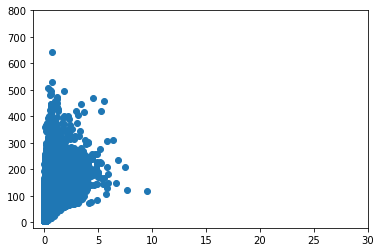

In [91]:
fig = plt.figure()
plt.scatter(np.delete(scores, ind), np.delete(blob_areas, ind))
plt.xlim([-1, 30])
plt.ylim([-20, 800])


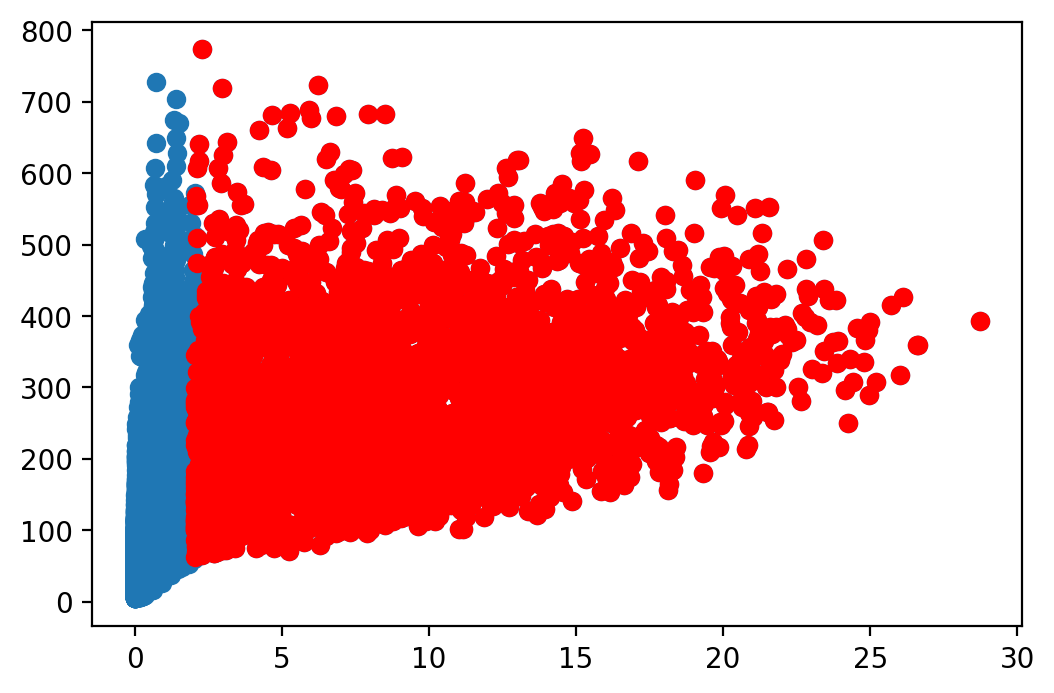

In [70]:
quant = np.quantile(scores, 1 - 1/41)
z = np.where(scores > quant)[0]
x = scores[z]
y = blob_areas[z]
fig = plt.figure()
fig.set_dpi(200)
plt.scatter(scores, blob_areas)
plt.scatter(x,y, c='r')

In [34]:
import plotly
import plotly.express as px

df = pd.DataFrame(data=np.vstack((scores, blob_areas)).T, columns=['score', ' area'])
px.scatter(data_frame=df, x = df.columns[0], y = df.columns[1])


In [35]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.expand_dims(scores, -1)
y = blob_areas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)





In [36]:
#build regression tree
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

Text(0.5, 1.0, 'Test Set')

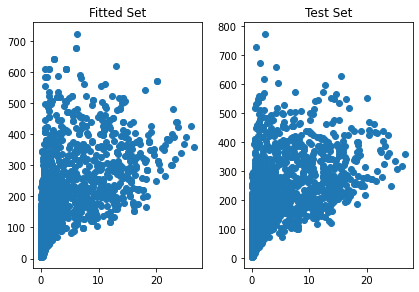

In [37]:
fig, ax = plt.subplots(1,2)
fig.tight_layout()
pred = regressor.predict(X_test)
ax[0].scatter(X_test, pred)
ax[0].set_title("Fitted Set")
ax[1].scatter(X_test, y_test)
ax[1].set_title("Test Set")

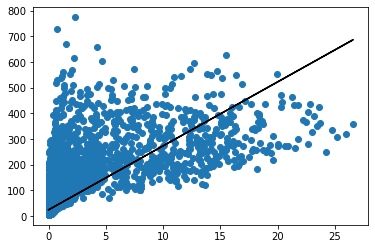

In [38]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

pred = lin_reg.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, pred, c = 'black')